In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!git clone https://github.com/ronakdm/input-marginalization.git

Cloning into 'input-marginalization'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 60 (delta 29), reused 51 (delta 23), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [3]:
%%bash
cd input-marginalization
git pull
cd ..

Already up to date.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
save_dir = "/content/gdrive/My Drive/input-marginalization"

Mounted at /content/gdrive


In [5]:
import pickle
import numpy as np
import time
import datetime
import random
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

In [6]:
try:
    from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
except ModuleNotFoundError:
    !pip install transformers
    from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
    

     |████████████████████████████████| 1.8MB 5.5MB/s 
     |████████████████████████████████| 890kB 26.0MB/s 
     |████████████████████████████████| 3.2MB 32.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=55721c399d6c62f604d6ccb1a56666b5791e09a9ec5ac60a0a4efa572ed96780
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
LEARNING_RATE = 1e-4
ADAMW_TOLERANCE = 1e-8
BATCH_SIZE = 10


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Running on '%s'." % device)

Running on 'cuda'.


In [8]:
def load_dataset(dataset_name):
    # `dataset_name` can be "train", "valid", or "test".
    input_ids = pickle.load(open("input-marginalization/preprocessed_data/SST-2/input_ids_%s" % dataset_name, "rb"))
    attention_masks = pickle.load(open("input-marginalization/preprocessed_data/SST-2/attention_masks_%s" % dataset_name, "rb"))
    labels = pickle.load(open("input-marginalization/preprocessed_data/SST-2/labels_%s" % dataset_name, "rb"))

    return TensorDataset(input_ids, attention_masks, labels)


train_dataset = load_dataset("train")
val_dataset = load_dataset("valid")

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = BATCH_SIZE)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = BATCH_SIZE)

print('{:>5,} training samples.'.format(len(train_dataset)))
print('{:>5,} validation samples.'.format(len(val_dataset)))

6,919 training samples.
  876 validation samples.


In [9]:
import pickle
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [10]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [11]:
#specified parameters in  the paper
embedding_dim = 100
num_filters = 100

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
total_t0 = time.time()
save_filename = "cnn_sst2"
training_stats = []
test_stats =[]
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size):
        super(CNN, self).__init__()
        self.embeddings = nn.Embedding(len(tokenizer.vocab),embedding_dim)
        self.convs = nn.ModuleList([nn.Conv1d(1, 100, (n, embedding_dim)) for n in (3,4,5)])        
        self.dropout_train, self.dropout_test = nn.Dropout(p = 0.5), nn.Dropout(p = 0)
        self.linear = nn.Linear(in_features=in_channels, out_features=out_channels, bias = True)
    
    def forward(self, x, train = True):
        
        embedded = self.embeddings(x)
        embedded = embedded.unsqueeze(1)
        
        convolved = [nn.functional.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        
        pooled = [nn.functional.max_pool1d(convd, convd.size(2)).squeeze(2) for convd in convolved]
        
        concatted = torch.cat(pooled, 1)
        
        dropped = self.dropout_train(concatted) if train else self.dropout_test(concatted)
        
        output = self.linear(dropped)
        
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits
        
    def predict(self, x):
        logits = self.forward(x, train = False)
        return logits.max(1)[1]
    
    def train(self, train_dataloader,validation_dataloader, num_epochs=15, learning_rate = LEARNING_RATE):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
        loss_vec = []
       
        for epoch in (range(num_epochs)):
            t0 = time.time()
            epoch_loss = 0
            for batch in train_dataloader:
                x = batch[0].to(device)
                y = batch[2].to(device)               
                optimizer.zero_grad()            
                y_p = self.forward(x)               
                
                loss = criterion(y_p, y)
                
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.data
                
            self.model = model     
            loss_vec.append(epoch_loss / len(train_dataloader))

                        
            training_time = format_time(time.time() - t0)

            acc,validation_time = self.validate(validation_dataloader)
            print('Epoch {} loss: {} | acc: {}'.format(epoch+1, loss_vec[epoch-1], acc))
            print("  Training epcoh {} took: {:}".format(epoch+1, training_time))
            self.model = model

            training_stats.append(
                {
                'epoch': epoch + 1,
                'Training Loss': loss_vec[epoch-1],               
                'Valid. Accur.': acc,
                'Training Time': training_time,
                'Validation Time': validation_time
                }
            )


        plt.plot(range(len(loss_vec)), loss_vec)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        print('\nModel trained.\n')
        self.loss_vec = loss_vec
        self.model = model
        pickle.dump(training_stats, open(f"{save_dir}/training_stats_{save_filename}.p", "wb"))
        
    def test(self, test_dataloader):
        t0 = time.time()
        
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_dataloader:
            
            x, y = batch[0].to(device), batch[2].to(device)
            probs = self.predict(x)[:len(y)]
            upload += list(probs.data)
            trues += list(y.data)

        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = correct / len(trues)
        print('Testset Accuracy:', accuracy)
        test_time = format_time(time.time()-t0)
        test_stats = {
        
        'Test Accur.': accuracy,
        'Test Time': test_time,
        }
        pickle.dump(test_stats, open(f"{save_dir}/test_stats_{save_filename}.p", "wb"))
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        t0 = time.time()
        for batch in val_iter:
            x, y = batch[0].to(device), batch[2].to(device)
            probs = self.predict(x)[:len(y)]
           
            y_p += list(probs.data) 
            y_t += list(y.data)
            
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = correct / len(y_p)
        validation_time = format_time(time.time() - t0)
        return accuracy,validation_time

Epoch 1 loss: 0.7644498944282532 | acc: 0.6141552511415526
  Training epcoh 1 took: 0:00:02
Epoch 2 loss: 0.7644498944282532 | acc: 0.6381278538812786
  Training epcoh 2 took: 0:00:02
Epoch 3 loss: 0.6939343214035034 | acc: 0.6735159817351598
  Training epcoh 3 took: 0:00:02
Epoch 4 loss: 0.6451854705810547 | acc: 0.678082191780822
  Training epcoh 4 took: 0:00:02
Epoch 5 loss: 0.6071372628211975 | acc: 0.6997716894977168
  Training epcoh 5 took: 0:00:02
Epoch 6 loss: 0.5762999057769775 | acc: 0.6929223744292238
  Training epcoh 6 took: 0:00:02
Epoch 7 loss: 0.5446448922157288 | acc: 0.7134703196347032
  Training epcoh 7 took: 0:00:02
Epoch 8 loss: 0.5095269680023193 | acc: 0.7157534246575342
  Training epcoh 8 took: 0:00:02
Epoch 9 loss: 0.47598177194595337 | acc: 0.7271689497716894
  Training epcoh 9 took: 0:00:02
Epoch 10 loss: 0.44583994150161743 | acc: 0.728310502283105
  Training epcoh 10 took: 0:00:02
Epoch 11 loss: 0.4136006832122803 | acc: 0.728310502283105
  Training epcoh 11

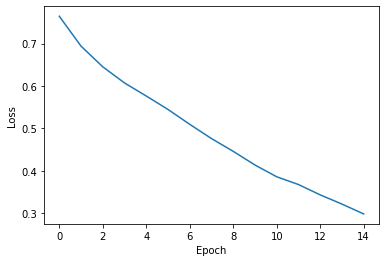


Model trained.

1,822 test samples.
Testset Accuracy: 0.7442371020856202


In [12]:
model = CNN(in_channels = 300, out_channels = 2, batch_size = BATCH_SIZE).to(device)
model.train(train_dataloader = train_dataloader, validation_dataloader = validation_dataloader, num_epochs=15, learning_rate = LEARNING_RATE)
test_dataset = load_dataset("test")
test_dataloader = DataLoader(test_dataset, sampler = RandomSampler(test_dataset), batch_size = BATCH_SIZE)
print('{:>5,} test samples.'.format(len(test_dataset)))


model.test(test_dataloader)

In [13]:

torch.save(model, f"{save_dir}/{save_filename}.pt")